In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , Input
from sklearn.model_selection import train_test_split

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [3]:
URI='/content/ENB2012_data.xlsx'
# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
train,test=train_test_split(df,test_size=0.2)

In [5]:
train_stats=train.describe()

In [6]:
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [7]:
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.763664,0.106332,0.62,0.660,0.74,0.85,0.98
X2,614.0,672.233713,88.336828,514.50,594.125,686.00,759.50,808.50
X3,614.0,317.662052,43.677898,245.00,294.000,318.50,343.00,416.50
X4,614.0,177.285831,45.208890,110.25,147.000,220.50,220.50,220.50
X5,614.0,5.221498,1.751195,3.50,3.500,3.50,7.00,7.00
X6,614.0,3.513029,1.102715,2.00,3.000,4.00,4.00,5.00
X7,614.0,0.236075,0.132970,0.00,0.100,0.25,0.40,0.40
X8,614.0,2.791531,1.532314,0.00,2.000,3.00,4.00,5.00


In [8]:
#model building 
input_layer=tf.keras.layers.Input(shape=(len(train.columns)))
first_layer=tf.keras.layers.Dense(units='128',activation='relu')(input_layer)
second_layer=tf.keras.layers.Dense(units='128',activation='relu')(first_layer)
third_layer=tf.keras.layers.Dense(units='128',activation='relu')(second_layer)
first_output=tf.keras.layers.Dense(units='1', name='y1_output')(second_layer)
second_output=tf.keras.layers.Dense(units='1',name='y2_output')(third_layer)
model=tf.keras.Model(inputs=input_layer,outputs=[first_output,second_output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          16512       ['dense_1[0][0]']                
                                                                                              

In [10]:
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss={'y1_output': 'mse', 'y2_output': 'mse'},
    metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()}
)

In [11]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 3s 14ms/step - loss: 199.1673 - y1_output_loss: 94.6357 - y2_output_loss: 104.5315 - y1_output_root_mean_squared_error: 9.7281 - y2_output_root_mean_squared_error: 10.2241 - val_loss: 31.6977 - val_y1_output_loss: 13.9821 - val_y2_output_loss: 17.7156 - val_y1_output_root_mean_squared_error: 3.7393 - val_y2_output_root_mean_squared_error: 4.2090
Epoch 2/500
62/62 [==============================] - 0s 4ms/step - loss: 32.2948 - y1_output_loss: 12.7830 - y2_output_loss: 19.5118 - y1_output_root_mean_squared_error: 3.5753 - y2_output_root_mean_squared_error: 4.4172 - val_loss: 67.1752 - val_y1_output_loss: 19.3850 - val_y2_output_loss: 47.7902 - val_y1_output_root_mean_squared_error: 4.4028 - val_y2_output_root_mean_squared_error: 6.9130
Epoch 3/500
62/62 [==============================] - 0s 4ms/step - loss: 26.0303 - y1_output_loss: 10.1645 - y2_output_loss: 15.8658 - y1_output_root_mean_squared_error: 3.1882 - y2_output_root_mean_squ

In [12]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 8ms/step - loss: 1.1627 - y1_output_loss: 0.2526 - y2_output_loss: 0.9101 - y1_output_root_mean_squared_error: 0.5026 - y2_output_root_mean_squared_error: 0.9540
Loss = 1.1626869440078735, Y1_loss = 0.25262051820755005, Y1_mse = 0.5026136636734009, Y2_loss = 0.9100663661956787, Y2_mse = 0.9539740085601807


5/5 [==============================] - 0s 6ms/step


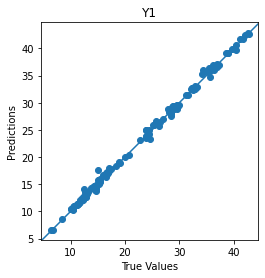

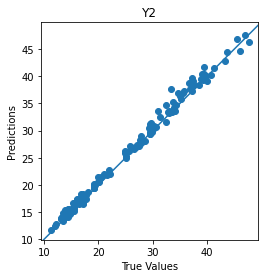

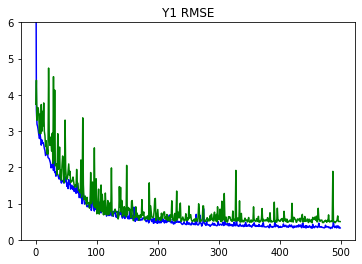

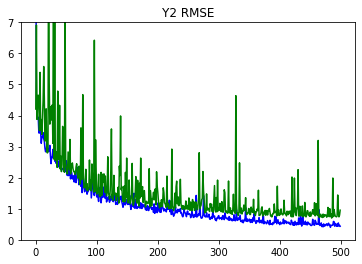

In [13]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)